# Setup

In [1]:
import time
import json
import spacy
import numpy as np
import pandas as pd
import seaborn as sn
import networkx as nx
import sklearn.metrics as skm
import matplotlib.pyplot as plt 

from pprint import pprint
from collections import Counter
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
predictions_path = '../out/predictions_20ng.csv'
predictions = pd.read_csv(predictions_path)
print('Total # of docs:', len(predictions), '\n')
predictions.head(3)

Total # of docs: 11314 



id                   true  ...  gsdmm_topic_2  gsdmm_score_2
0   0              rec.autos  ...             11   2.122357e-17
1   1  comp.sys.mac.hardware  ...              4   5.241309e-31
2   2  comp.sys.mac.hardware  ...              2   0.000000e+00

[3 rows x 26 columns]

In [0]:
models   = ['lda', 'lftm', 'ntm', 'gsdmm']
n_topics = 20
topics   = range(n_topics)
labels   = sorted(predictions['true'].unique())
n_labels = len(labels)
n_preds  = 1

In [0]:
for model in models:
  ! wget -q ../out/{model}_topics_20ng.json

In [5]:
label_ids = {label:i for i, label in enumerate(labels)}
reverse_label_ids = {i:label for label,i in label_ids.items()}
label_ids

{'alt.atheism': 0,
 'comp.graphics': 1,
 'comp.os.ms-windows.misc': 2,
 'comp.sys.ibm.pc.hardware': 3,
 'comp.sys.mac.hardware': 4,
 'comp.windows.x': 5,
 'misc.forsale': 6,
 'rec.autos': 7,
 'rec.motorcycles': 8,
 'rec.sport.baseball': 9,
 'rec.sport.hockey': 10,
 'sci.crypt': 11,
 'sci.electronics': 12,
 'sci.med': 13,
 'sci.space': 14,
 'soc.religion.christian': 15,
 'talk.politics.guns': 16,
 'talk.politics.mideast': 17,
 'talk.politics.misc': 18,
 'talk.religion.misc': 19}

In [6]:
predictions['label_id'] = [label_ids[label] for label in predictions['true']]
predictions[['id', 'true', 'label_id']].head()

id                   true  label_id
0   0              rec.autos         7
1   1  comp.sys.mac.hardware         4
2   2  comp.sys.mac.hardware         4
3   3          comp.graphics         1
4   4              sci.space        14

In [7]:
docs_per_label = predictions['true'].value_counts().to_dict()
predictions['true'].value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: true, dtype: int64

# Voting for topics

**Input:** 
* `n_topics`: number of topics 
* `n_preds`: number of predictions per document 
* `models`: list of trained TMs names 
* `predictions[label_id, tm_topic_k, tm_score_k]`: top *n_topics* predicted topic ids and the prediction confidence for each document with its ground truth label 

**Output:** 
* `probs[model, label_j, topic_i]`: sum of contributions (scores) from all document to the likelihood that topic T_i maps to label L_j 
* `votes[model, label_j, topic_i]`: number of such contributions 

In [10]:
%%time
probs    = {model: {l: {t: 0. for t in topics} for l in range(n_labels)} for model in models}
votes    = {model: {l: {t: 0. for t in topics} for l in range(n_labels)} for model in models}

for i, doc in predictions.iterrows():
  for model in models:
    label = doc['label_id']
    for k in range(n_preds):
      t, p = doc[f'{model}_topic_{k}'], doc[f'{model}_score_{k}']
      if int(t) >= 0: # sometimes the model outputs -1, we discard those results
        probs[model][label][t] += p 
        votes[model][label][t] += 1 if p > 0 else 0 # we only count the contribution if it's positive

CPU times: user 2.6 s, sys: 1.78 ms, total: 2.6 s
Wall time: 2.6 s


In [11]:
# Example : the score for LDA's topic_13 ('atheist, morality, moral, god,..') to be mapped to label_0 ("alt.atheism") 
print("probs['lda'][0][13] =", probs['lda'][0][13])

probs['lda'][0][13] = 164.84800521228243


# Finding the Mapping

**Input:** 
* `probs[model, label_j, topic_i]` and `votes[model, label_j, topic_i]`: from previous block
* `docs_per_label`: number of docs per label (for normalization)

**Output:** 
* `topic_dfs[model, scoring_model]`: Score matrices for each Label/Topic potential matching for all LMs using different counting/normalization options (sorted so that the label with the largest number of mapped topics is first for better visualization)
* visualizations for each LM/scoring methods in matrices
* `topic_mappings[model, scoring_model, topic]`: the mapping from topics to label_ids per LM/scoring 
* `reverse_topic_mappings[model, scoring_model, label_id]`: the mapping from label_id to a list of topics per LM/scoring method

CPU times: user 6.02 s, sys: 2.19 s, total: 8.21 s
Wall time: 5.96 s


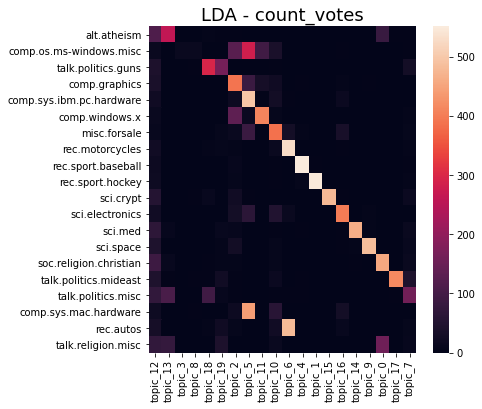

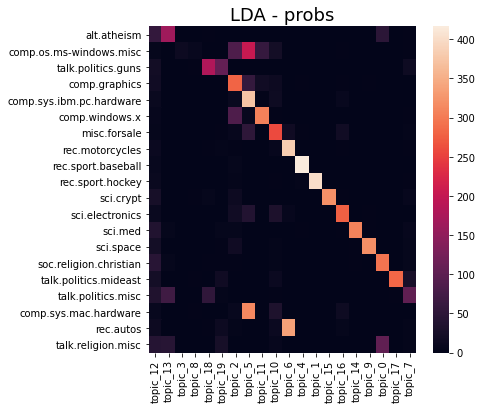

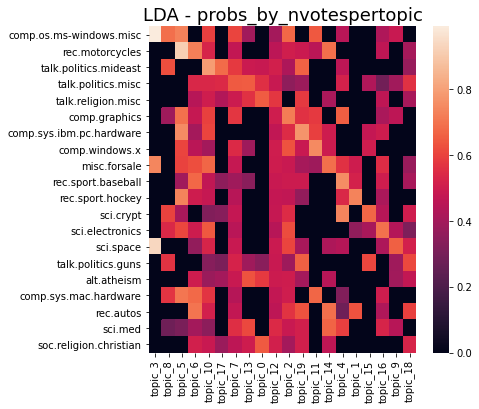

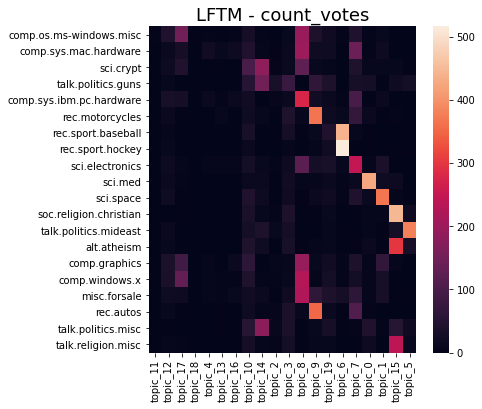

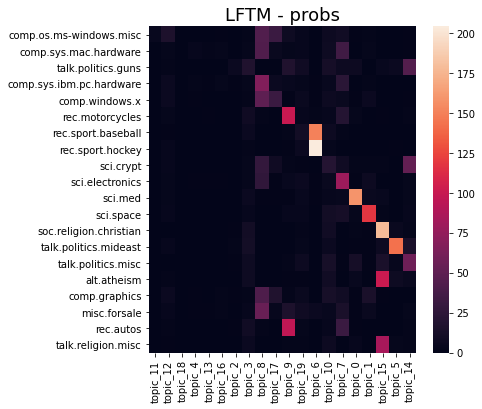

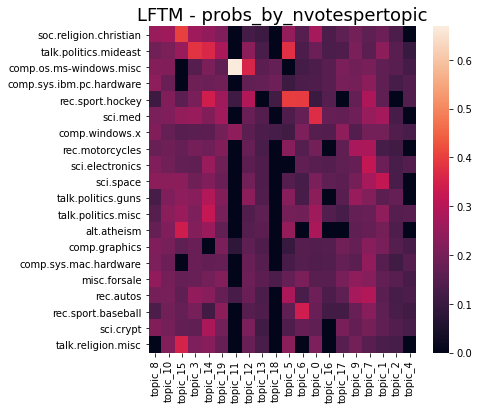

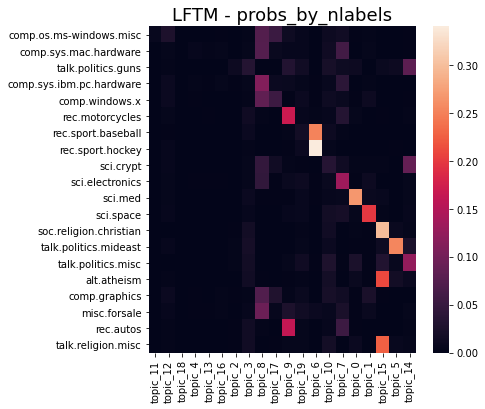

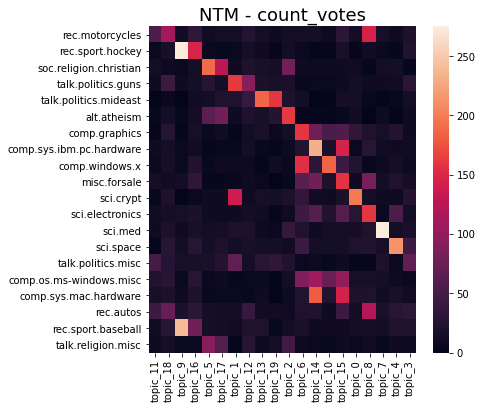

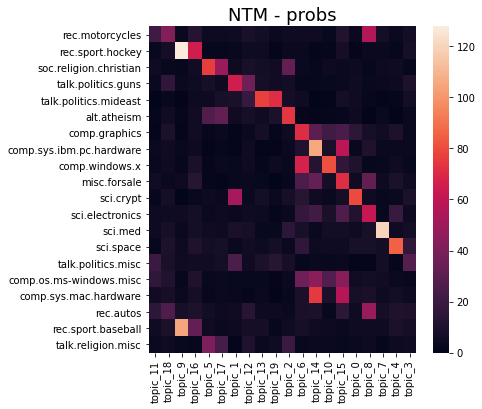

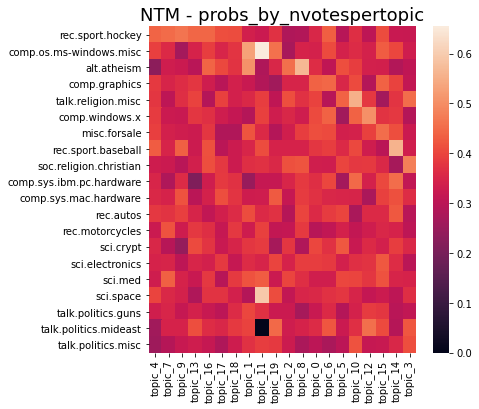

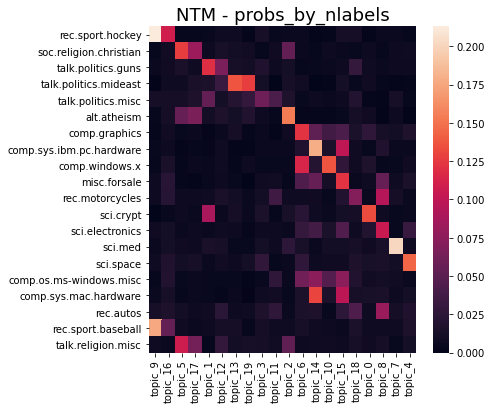

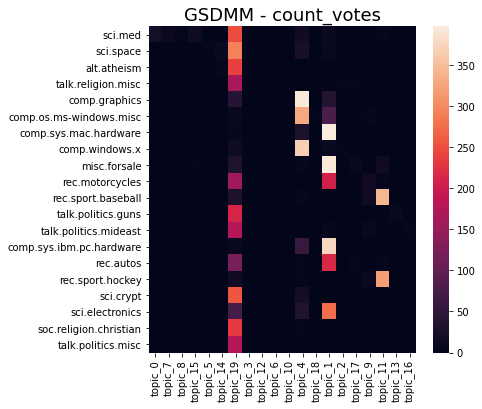

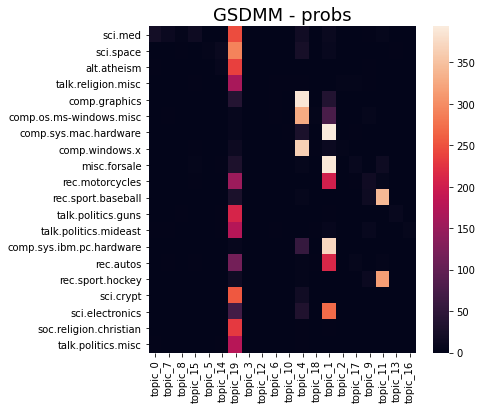

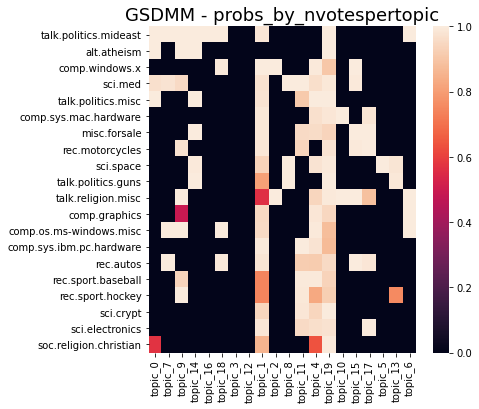

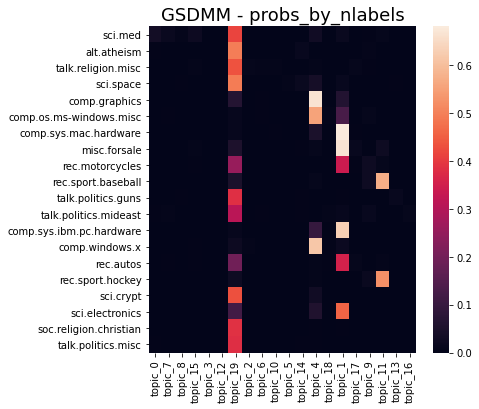

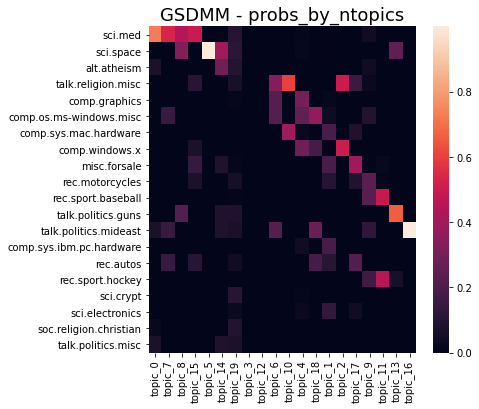

In [13]:
%%time
# We divide each score by the number of contributions (votes) for it, eliminating some overrepresentation bias
n_probs  = {model: {l: {t: probs[model][l][t]/max(votes[model][l][t], 1) for t in topics} for l in range(n_labels)} for model in models}
# We divide each score by the number documents originally in that label,  eliminating some overrepresentation bias
n2_probs = {model: {l: {t: probs[model][l][t]/docs_per_label[reverse_label_ids[l]] for t in topics} for l in range(n_labels)} for model in models}
n3_probs = {model: {l: {t: probs[model][l][t]/max(sum(votes[model][ll][t] for ll in range(n_labels)), 1) for t in topics} for l in range(n_labels)} for model in models}

topic_dfs = {}
topic_mappings = {}
reverse_topic_mappings = {}
scoring_methods = {'count_votes': votes, 'probs': probs, 'probs_by_nvotespertopic': n_probs, 'probs_by_nlabels': n2_probs, 'probs_by_ntopics': n3_probs,}

for model in models: 
  topic_dfs[model] = {}
  topic_mappings[model] = {}
  reverse_topic_mappings[model] = {}
  topics_json = json.load(open(model+'_topics_20ng.json', 'r'))
  labels = [reverse_label_ids[t] for t in topics]

  for sm, scores in scoring_methods.items():
    topic_mapping = {}
    reverse_topic_mapping = {l:[] for l in labels}
  
    df = pd.DataFrame(scores[model]).transpose()
    df.columns = ['topic_' + str(t) for t in topics]
    df.index = labels

    for topic_id, topic in enumerate(df.columns):
      label_max = df[topic].idxmax()
      topic_mapping[topic_id] = label_max
      reverse_topic_mapping[label_max].append(topic_id)
    
    topic_mappings[model][sm] = topic_mapping
    reverse_topic_mappings[model][sm] = reverse_topic_mapping

    # For visualization purposes, we sort the Y-axis labels according to the number of topics mapped to them
    sorted_idx     = [l for l, ll in sorted(reverse_topic_mapping.items(), key=lambda x: len(x[1]), reverse=True)]
    # Then we sort the topics according to the label they map to
    sorted_columns = []
    for l in sorted_idx:
      sorted_columns.extend(['topic_'+str(t) for t in reverse_topic_mapping[l]])
    
    # in case we want the topics from 0 to 19
    # sorted_columns = ['topic_'+str(t) for t in range(n_topics)]
    df_sorted = df[sorted_columns].loc[sorted_idx]
    topic_dfs[model][sm] = df_sorted
 
    plt.figure(figsize=(6, 6))
    plt.title(model.upper() + ' - ' + sm, fontsize =18)
    sn.heatmap(df_sorted).get_figure().savefig(f"{model}_{sm}_topics.png")

# Evaluations

We show the label assigned to each topic (represented by its ID and keywords) 
(We only use `probs` scores to make the 

In [0]:
# We load the list of terms per topic for each model
topic_keywords = {}
for model in models:
  topics_json = json.load(open(model+'_topics_20ng.json', 'r'))
  topic_keywords[model] = {t: ', '.join(topics_json[str(t)]['words']) for t in topics}

We visualize the mapping between the labels and the topics (represented by their id and top words)

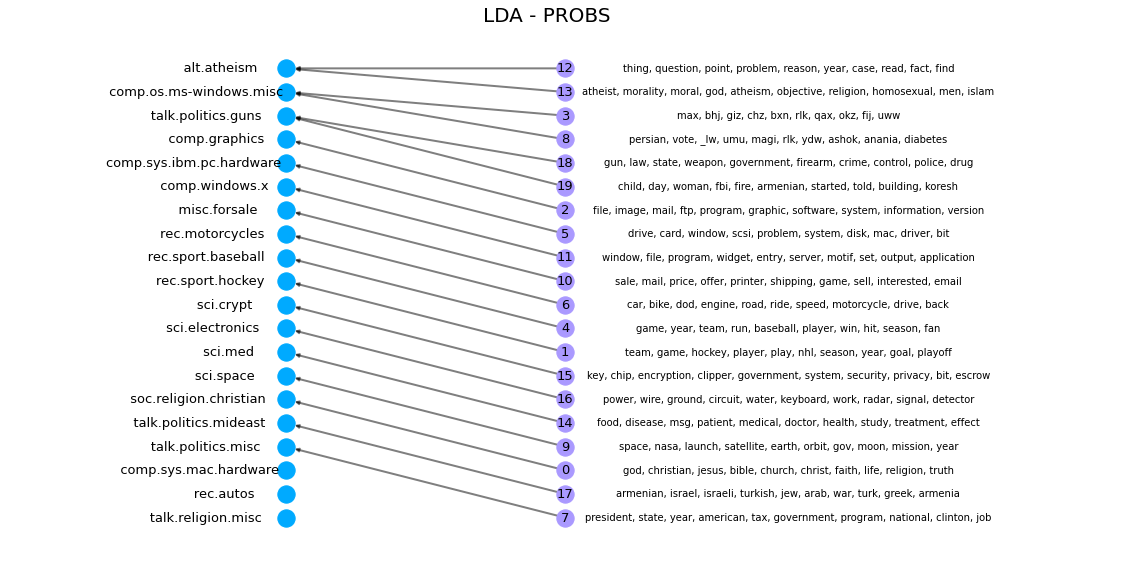

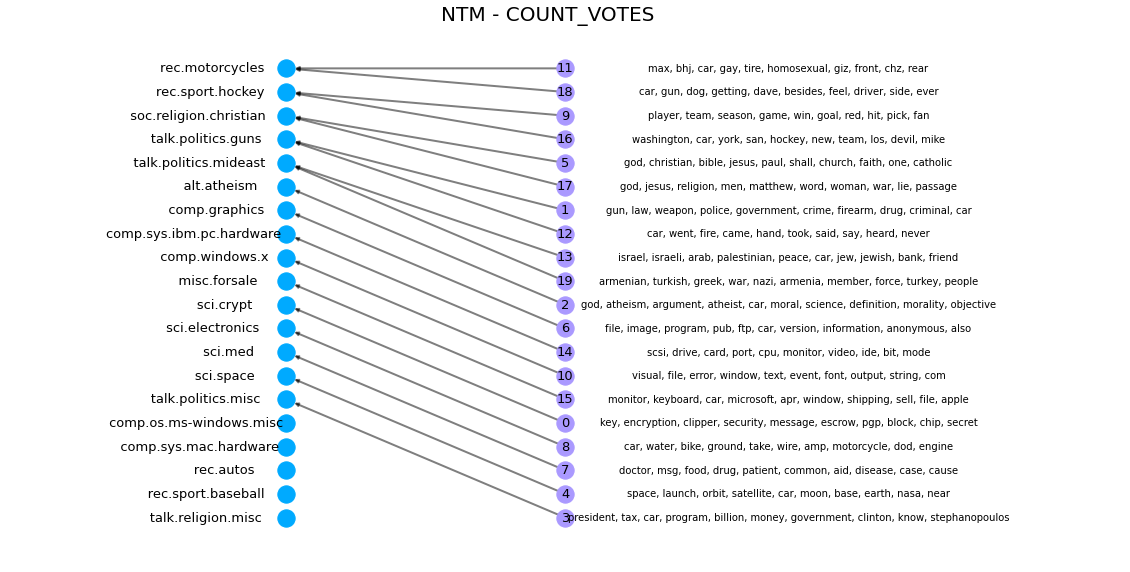

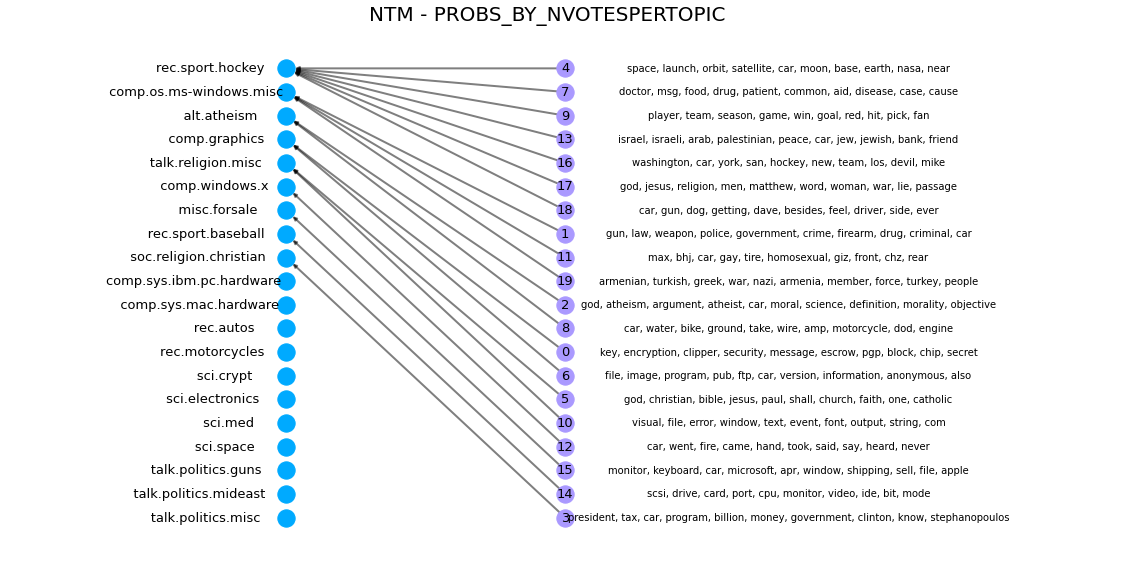

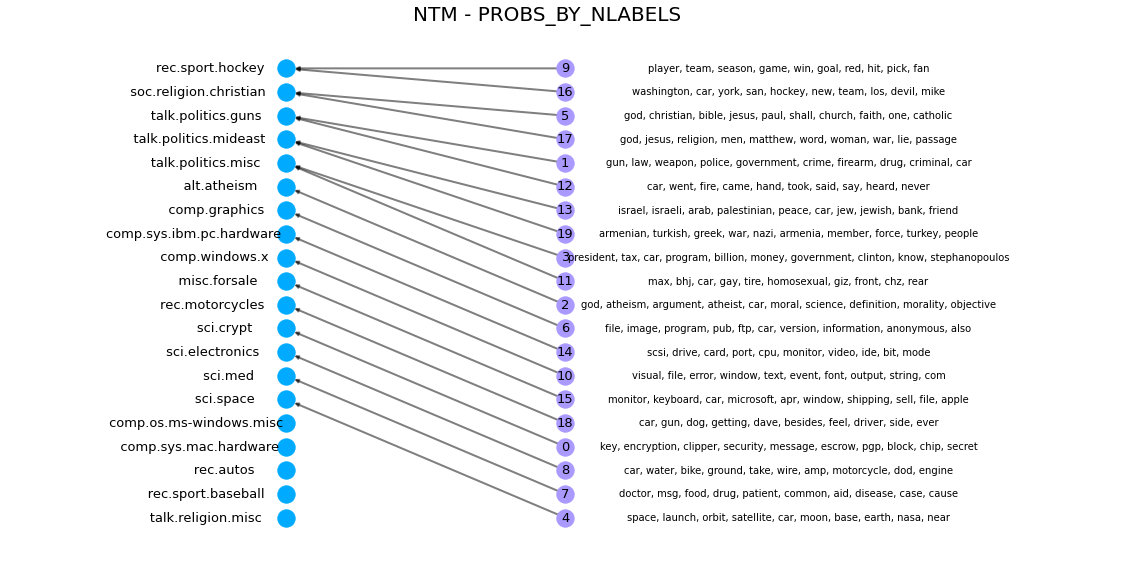

In [15]:
for model in models:
  for sm in topic_mappings[model]:
    m = topic_mappings[model][sm]
    topic_ids, mapped_labels = m.keys(), set(m.values())
    edges = m.items()

    fig, ax = plt.subplots(figsize=(20,10)) 
    ax.axis('off')

    G = nx.DiGraph()
    G.add_nodes_from(topic_ids, bipartite=0)
    G.add_nodes_from(mapped_labels, bipartite=1)
    G.add_edges_from(edges)

    # Set the position of each node on the graph
    pos = {}
    # We use the same ordering in the Scoring Visualization just to make it look pretty :) -no edges will intersect-
    ordered_labels = [l for l in topic_dfs[model][sm].index if l in mapped_labels] 
    ordered_labels = ordered_labels + [l for l in labels if l not in ordered_labels]
    ordered_topics = [int(i.split('_')[1]) for i in topic_dfs[model][sm].columns]
    pos.update((node, (0.5, n_topics - 1 - index)) for index, node in enumerate(ordered_labels))
    pos.update((node, (1.5, n_topics - 1 - index)) for index, node in enumerate(ordered_topics))

    # nx.draw(G, pos, with_labels=False)
    nx.draw_networkx_nodes(G,pos,
                            nodelist=ordered_labels, # mapped_labels,
                            node_size=300,
                            node_color='#0af')
    
    nx.draw_networkx_nodes(G,pos,
                            nodelist= topic_ids,
                            node_size=300,
                            node_color='#a9f')
    

    nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='-|>', width=2, arrowsize=7, edge_color='#000', alpha=0.5)

    pos_keywords = {k: (v[0]+0.8, v[1]) for k, v in pos.items()}
    pos_labels   = {k: (v[0]-0.45, v[1]) for k, v in pos.items()}

    nx.draw_networkx_labels(G,pos_labels, {l:str.rjust(l, 40) for l in ordered_labels},font_size=13) # mapped_labels},font_size=13)
    nx.draw_networkx_labels(G,pos, {t:t for t in topic_ids},font_size=13)
    nx.draw_networkx_labels(G,pos_keywords, topic_keywords[model],font_size=10)

    fig.suptitle(model.upper() + ' - ' + sm.upper(), fontsize=20, y=0.9)
    plt.xlim(-0.5, 3.5)
    plt.savefig(f'{model}_mapping_{sm}.png')
    plt.show()

In [16]:
metrics = ['r1_accuracy', 'r3_accuracy', 'purity', 'homogeneity', 'completeness', 'v_measure', 'average']
scores  = {}

for sm in scoring_methods:
  print('Scoring model:', sm.upper())
  for model in models:
    score   = {}
    topic_to_label = lambda t: '' if t == -1 else topic_mappings[model][sm][t]
    y_true    = predictions['true']
    y_pred    = predictions[model+'_topic_0'].apply(topic_to_label)
    y_pred_2  = predictions[model+'_topic_1'].apply(topic_to_label)
    y_pred_3  = predictions[model+'_topic_2'].apply(topic_to_label)
    contingency_matrix = skm.cluster.contingency_matrix(y_true, predictions[model+'_topic_0'])

    score['r1_accuracy']   = skm.accuracy_score(y_true, y_pred)
    score['r3_accuracy']   = skm.accuracy_score(y_true, y_pred) + skm.accuracy_score(y_true, y_pred_2) + skm.accuracy_score(y_true, y_pred_3)
    score['purity']        = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 
    score['homogeneity']   = skm.homogeneity_score(y_true, y_pred)
    score['completeness']  = skm.completeness_score(y_true, y_pred)
    score['v_measure']     = skm.v_measure_score(y_true, y_pred) # Also NMI
    score['average']       = np.average([s for k, s in score.items()])

    scores[model] = score

  header = 'model    ' + ' '.join(str.ljust(m, 13) for m in metrics)
  print(header)
  print('-'*len(header))
  for model in models:
    scorer = lambda model, metric: str.ljust(str(round(scores[model][metric]*100, 2))+'%', 13)
    print(model.upper(), '\t  ', ' '.join(scorer(model, metric) for metric in metrics))
  print('\n')

Scoring model: COUNT_VOTES
model    r1_accuracy   r3_accuracy   purity        homogeneity   completeness  v_measure     average      
----------------------------------------------------------------------------------------------------------
LDA 	   62.1%         80.11%        62.1%         60.4%         66.86%        63.47%        65.84%       
LFTM 	   32.89%        52.07%        32.89%        31.22%        37.87%        34.22%        36.86%       
NTM 	   29.33%        48.79%        29.33%        19.47%        21.91%        20.61%        28.24%       
GSDMM 	   15.92%        22.66%        16.63%        18.82%        37.44%        25.05%        22.75%       


Scoring model: PROBS
model    r1_accuracy   r3_accuracy   purity        homogeneity   completeness  v_measure     average      
----------------------------------------------------------------------------------------------------------
LDA 	   62.1%         80.11%        62.1%         60.4%         66.86%        63.47%        65.

In [0]:
# to generate code for LaTeX
metrics = ['Accuracy', 'Accuracy@3', 'Purity', 'Homogeneity', 'Completeness', 'V-Measure', 'Average']
scores  = {}
scores_print = {}
SMs  =  {'COUNT_VOTES': 'SM1', 'PROBS':"SM2", 'PROBS_BY_NVOTESPERTOPIC':"SM5", 'PROBS_BY_NLABELS':"SM3", 'PROBS_BY_NTOPICS': "SM4"}

for sm in scoring_methods:
  for model in models:
    if model not in scores_print: scores_print[model] = []
    score   = {}
    topic_to_label = lambda t: '' if t == -1 else topic_mappings[model][sm][t]
    y_true    = predictions['true']
    y_pred    = predictions[model+'_topic_0'].apply(topic_to_label)
    y_pred_2  = predictions[model+'_topic_1'].apply(topic_to_label)
    y_pred_3  = predictions[model+'_topic_2'].apply(topic_to_label)
    contingency_matrix = skm.cluster.contingency_matrix(y_true, predictions[model+'_topic_0'])

    score['Accuracy']   = skm.accuracy_score(y_true, y_pred)
    score['Accuracy@3']   = skm.accuracy_score(y_true, y_pred) + skm.accuracy_score(y_true, y_pred_2) + skm.accuracy_score(y_true, y_pred_3)
    score['Purity']        = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 
    score['Homogeneity']   = skm.homogeneity_score(y_true, y_pred)
    score['Completeness']  = skm.completeness_score(y_true, y_pred)
    score['V-Measure']     = skm.v_measure_score(y_true, y_pred) # Also NMI
    score['Average']       = np.average([s for k, s in score.items()])

    scores[model] = score

  for model in models:
    scorer = lambda model, metric: str.ljust(str(round(scores[model][metric]*100, 2))+'\%', 13)
    # print(model.upper(), '\t  ', ' '.join(scorer(model, metric) for metric in metrics))

    scores_print[model].append('& '.join([model.upper() + '  \t ', str.ljust(SMs[sm.upper()], 7), '& '.join(scorer(model, metric) for metric in metrics)]) + '\\\\')



header = 'model       &   ' + str.ljust('SM', 7)  + '& '+ '& '.join(str.ljust(m, 13) for m in metrics) + '\\\\'
print('  ', header)
print('  ', '-'*len(header))
for model in models:
  for sent in scores_print[model]:
    print('  ', sent)
  # print('  ', '-'*len(header))
  print('    \\hline')

# Greedy top-1 assignment

In [0]:
# We load the list of terms per topic for each model
topic_keywords = {}
for model in models:
  topics_json = json.load(open(model+'_topics_20ng.json', 'r'))
  topic_keywords[model] = {t: ', '.join(topics_json[str(t)]['words']) for t in topics}

CPU times: user 6.67 s, sys: 2.19 s, total: 8.85 s
Wall time: 6.62 s


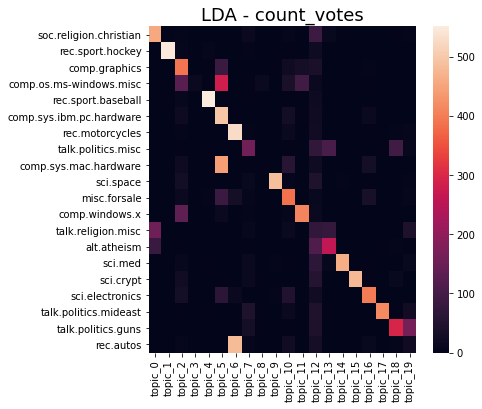

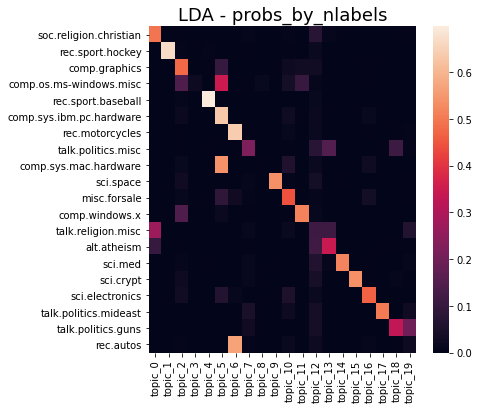

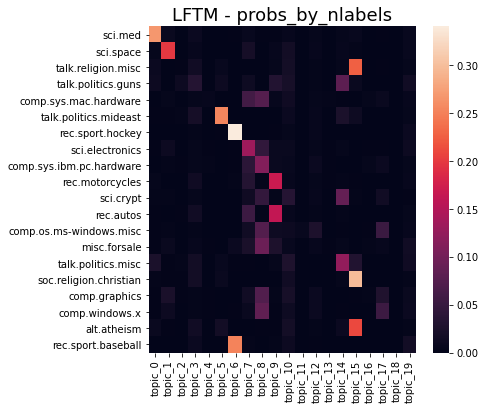

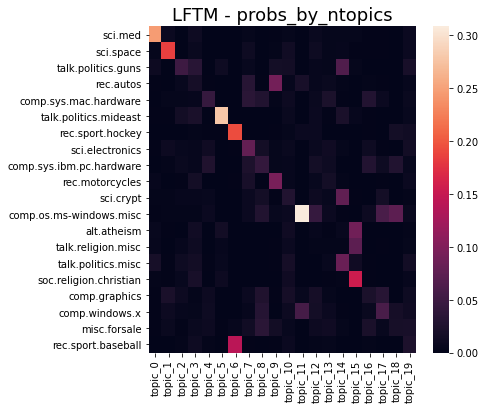

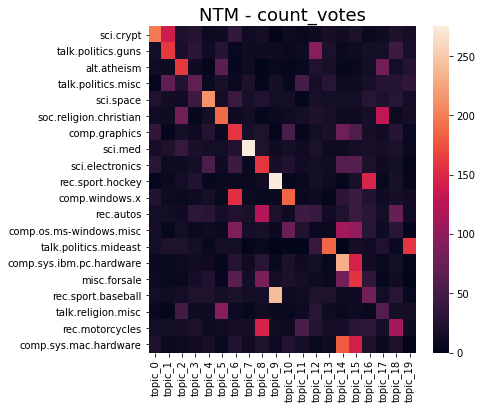

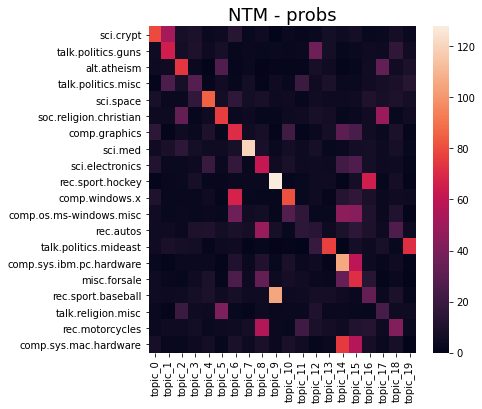

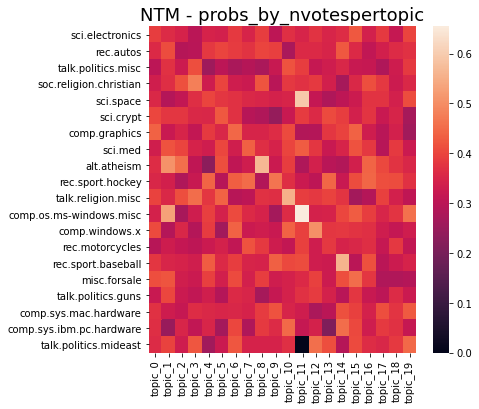

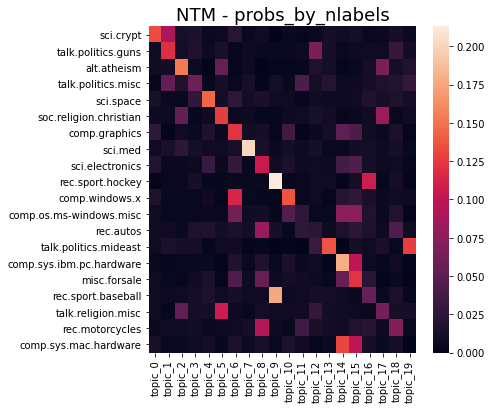

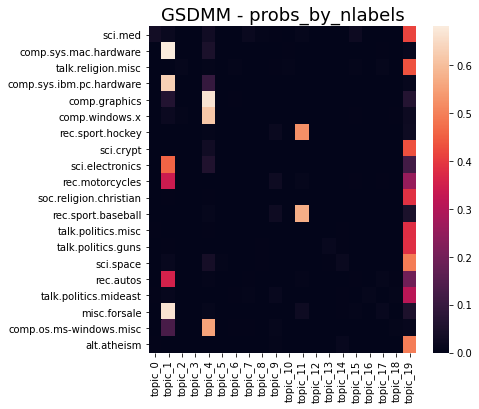

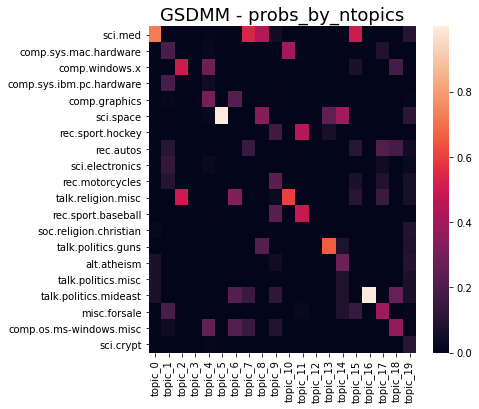

In [0]:
%%time
# We divide each score by the number of contributions (votes) for it, eliminating some overrepresentation bias
n_probs  = {model: {l: {t: probs[model][l][t]/max(votes[model][l][t], 1) for t in topics} for l in range(n_labels)} for model in models}
# We divide each score by the number documents originally in that label,  eliminating some overrepresentation bias
n2_probs = {model: {l: {t: probs[model][l][t]/docs_per_label[reverse_label_ids[l]] for t in topics} for l in range(n_labels)} for model in models}
n3_probs = {model: {l: {t: probs[model][l][t]/max(sum(votes[model][ll][t] for ll in range(n_labels)), 1) for t in topics} for l in range(n_labels)} for model in models}

topic_dfs = {}
topic_mappings = {}
reverse_topic_mappings = {}
scoring_methods = {'count_votes': votes, 'probs': probs, 'probs_by_nvotespertopic': n_probs, 'probs_by_nlabels': n2_probs, 'probs_by_ntopics': n3_probs,}

for model in models: 
  topic_dfs[model] = {}
  topic_mappings[model] = {}
  reverse_topic_mappings[model] = {}
  topics_json = json.load(open(model+'_topics_20ng.json', 'r'))
  labels = [reverse_label_ids[t] for t in topics]

  for sm, scores in scoring_methods.items():
    topic_mapping = {}
    reverse_topic_mapping = {}
  
    df = pd.DataFrame(scores[model]).transpose()
    df.columns = topics # ['topic_' + str(t) for t in topics]
    df.index = labels

    flat_topic_matrix = []
    for label, score in df.iterrows():
      flat_topic_matrix.extend([(topic, label, score[topic]) for topic in topics])

    sorted_flat_topic_matrix = sorted(flat_topic_matrix, key=lambda t: t[2], reverse=True)
    # greedy_mappings[method] : 
    for t in sorted_flat_topic_matrix:
      if t[0] not in topic_mapping and t[1] not in reverse_topic_mapping:
        topic_mapping[t[0]] = t[1]
        reverse_topic_mapping[t[1]] = t[0]

      if len(topic_mapping) == n_topics:
        break
    topic_mappings[model][sm] = topic_mapping
    reverse_topic_mappings[model][sm] = reverse_topic_mapping

    # For visualization purposes, we sort the Y-axis labels according to the number of topics mapped to them
    sorted_columns = topics
    sorted_idx     = [topic_mapping[t] for t in topics]
    
    df_sorted = df[sorted_columns].loc[sorted_idx]
    df_sorted = df_sorted.rename(columns={t:f'topic_{t}' for t in topics})
    topic_dfs[model][sm] = df_sorted
 
    plt.figure(figsize=(6, 6))
    plt.title(model.upper() + ' - ' + sm, fontsize =18)
    sn.heatmap(df_sorted).get_figure().savefig(f"{model}_{sm}_topics_greedy.png")

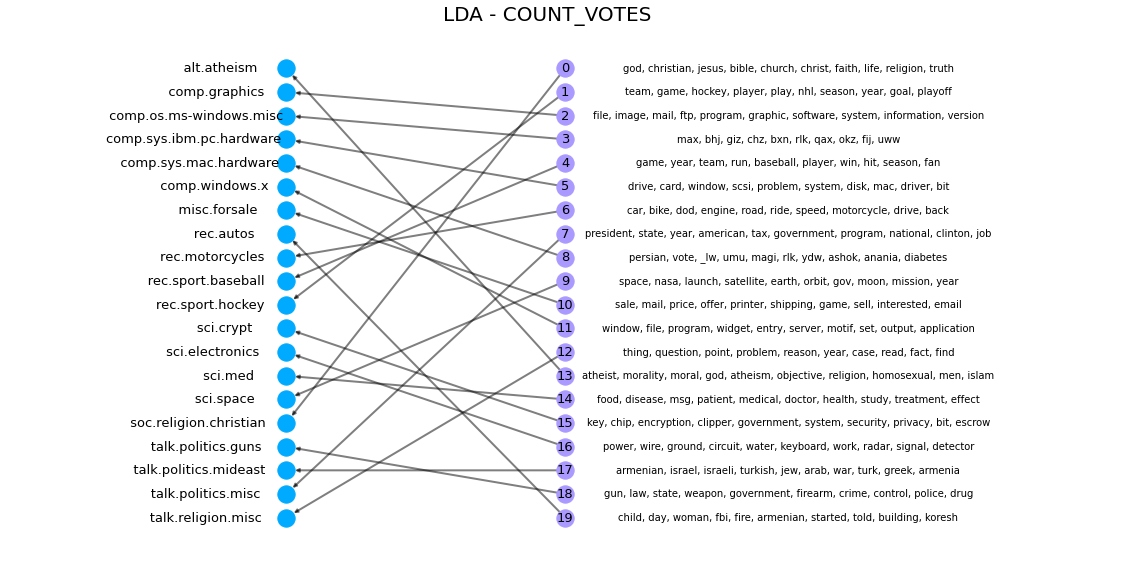

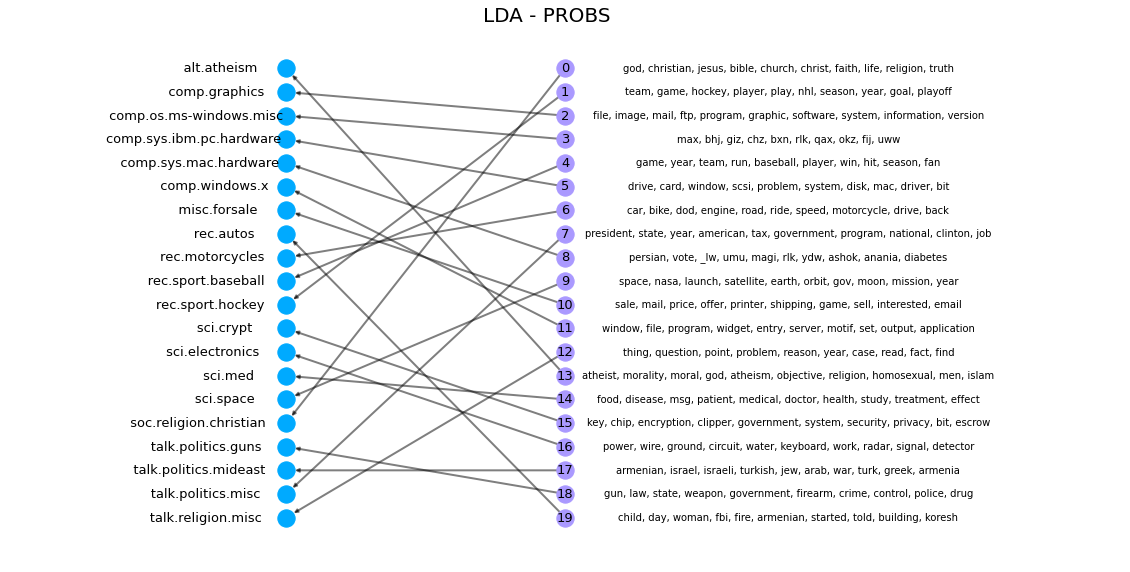

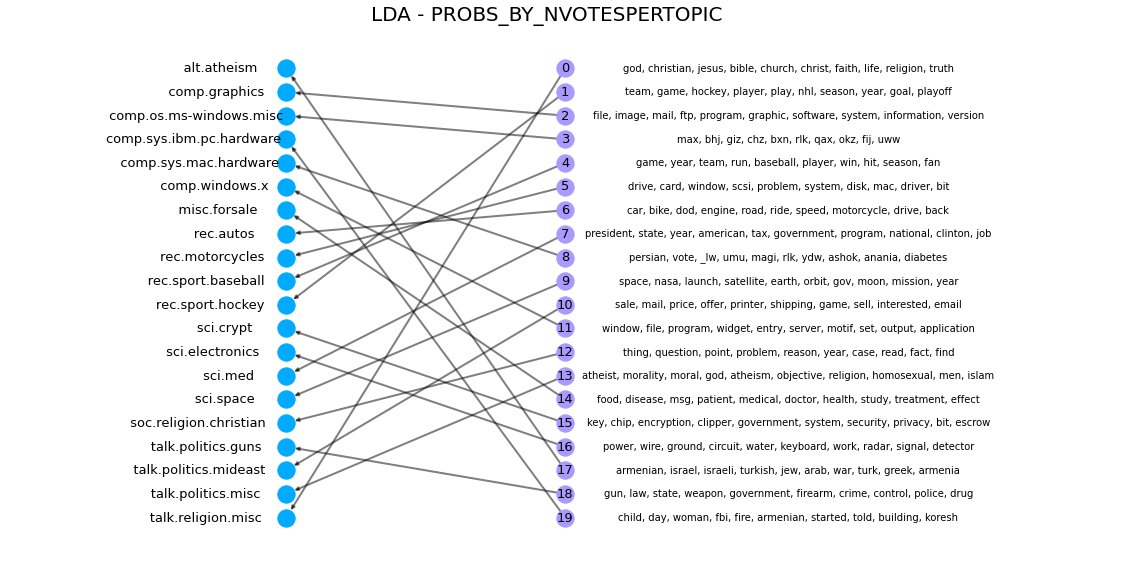

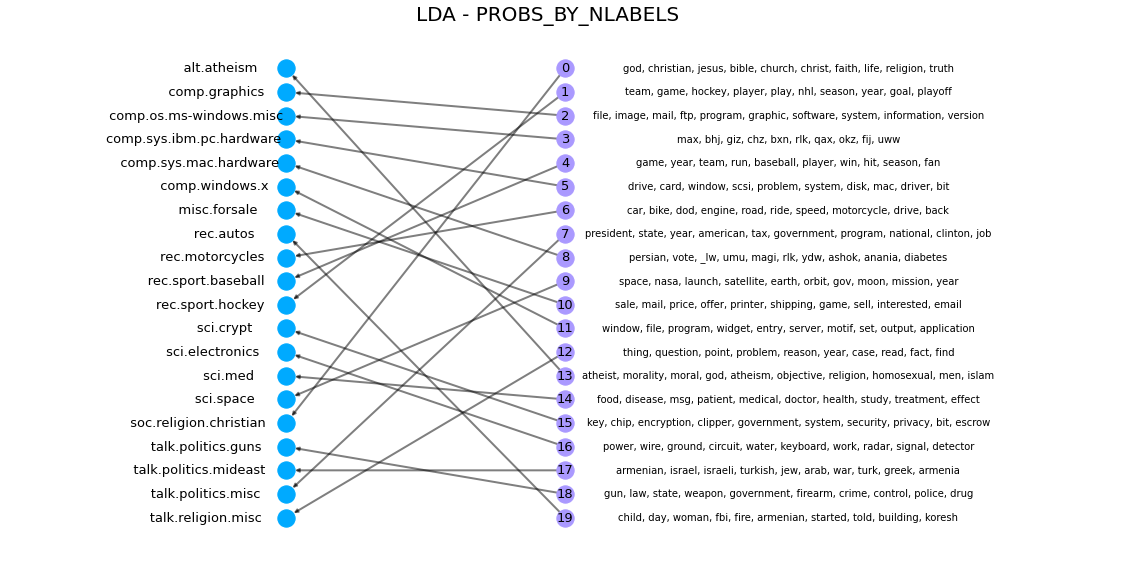

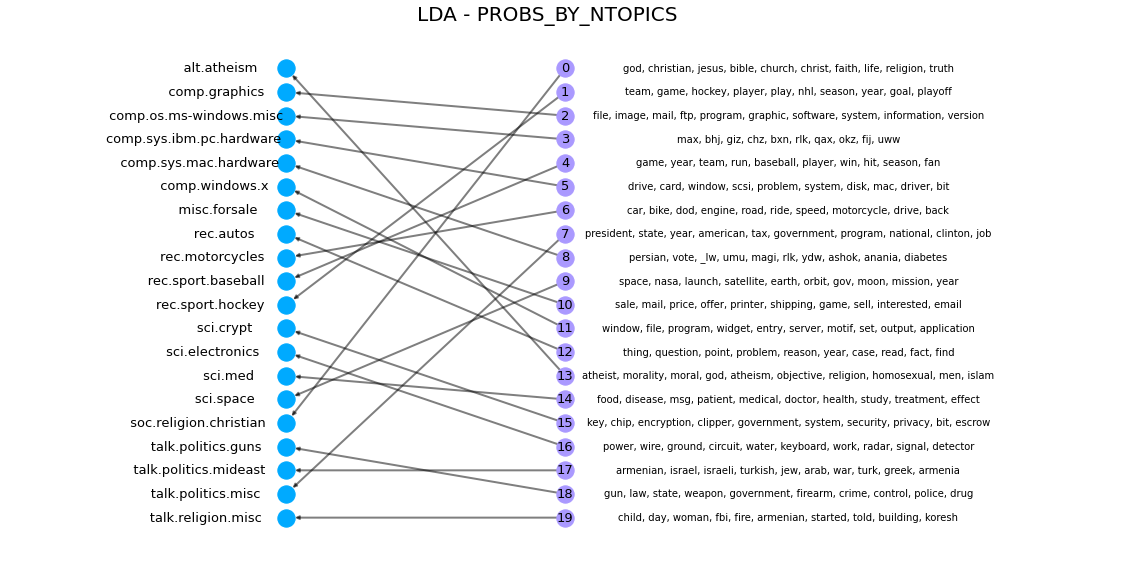

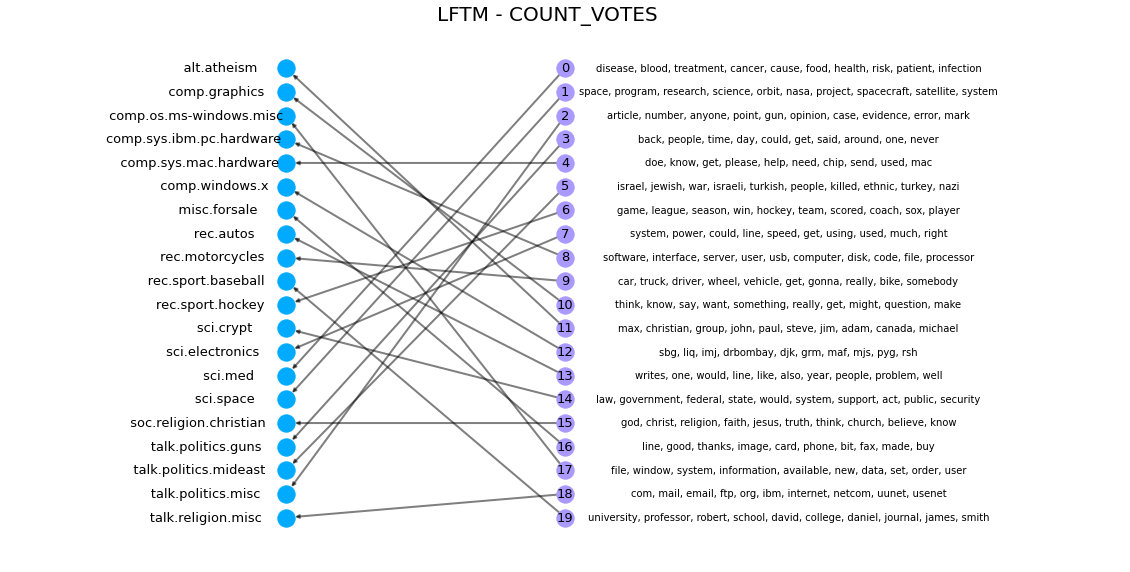

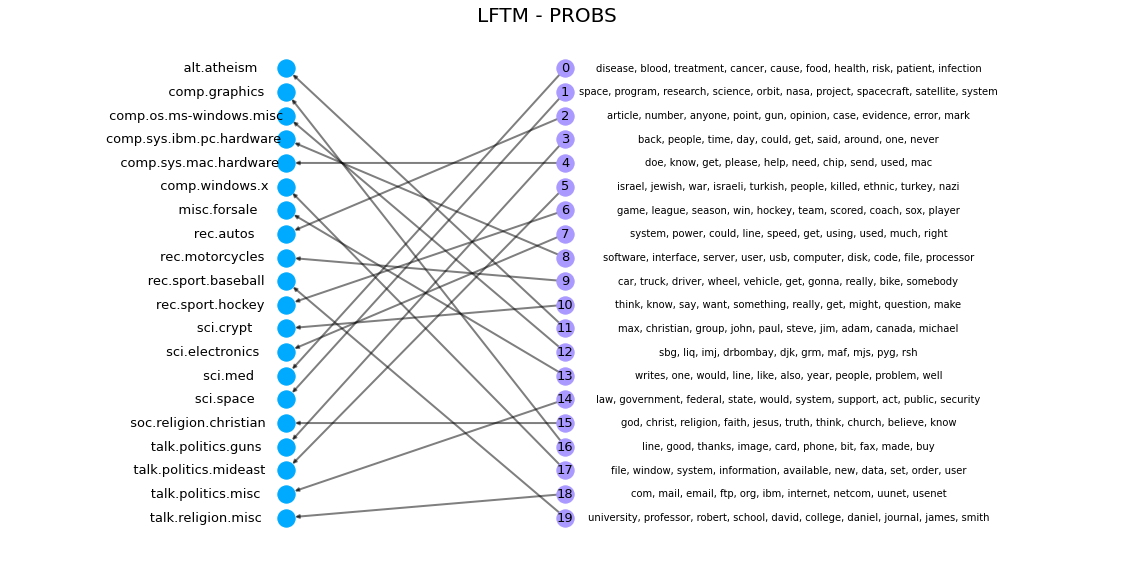

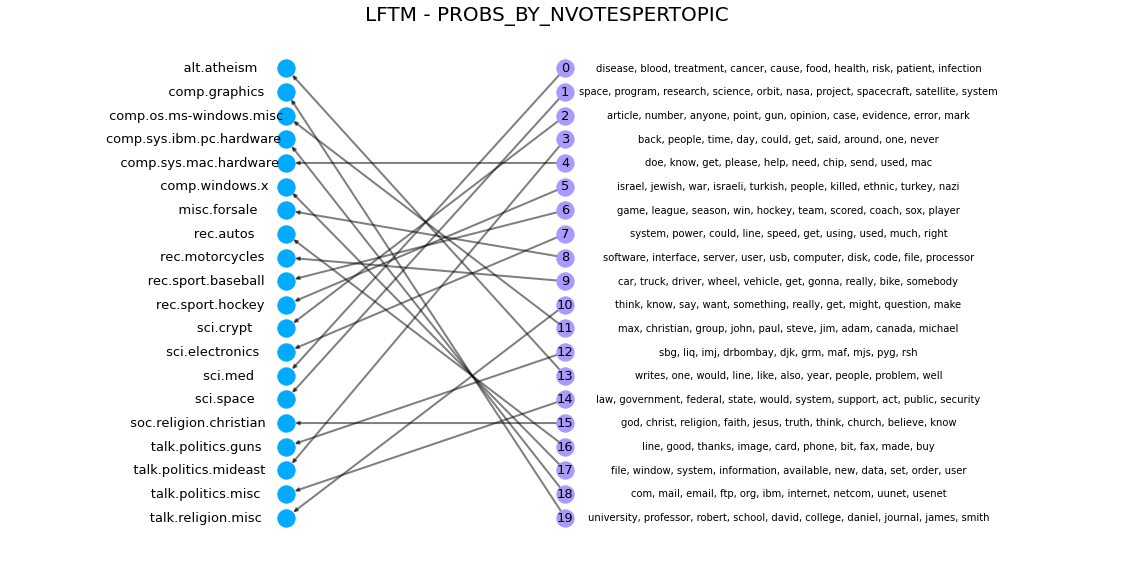

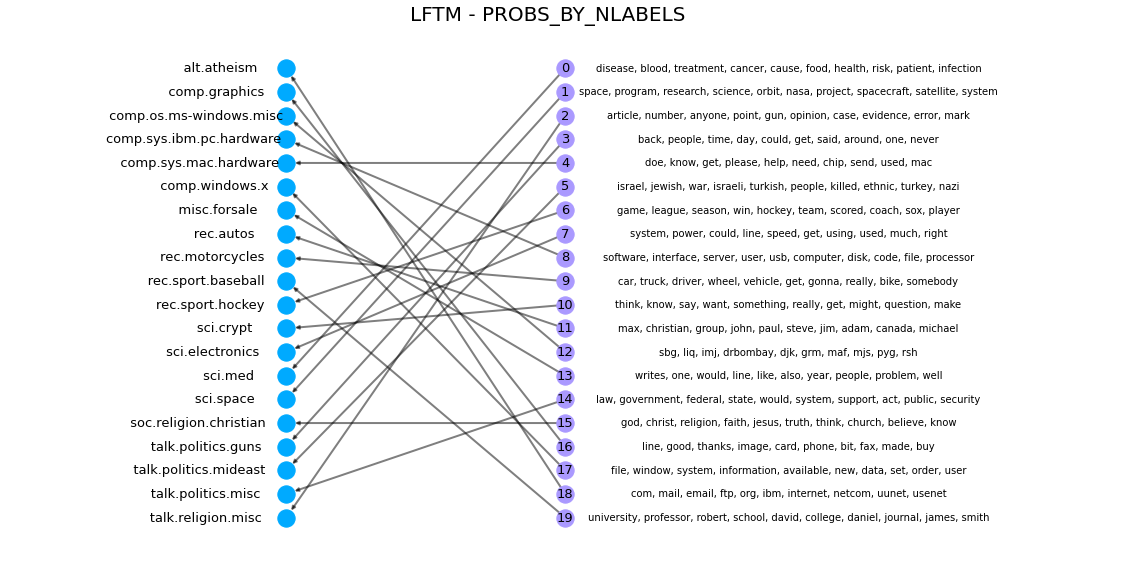

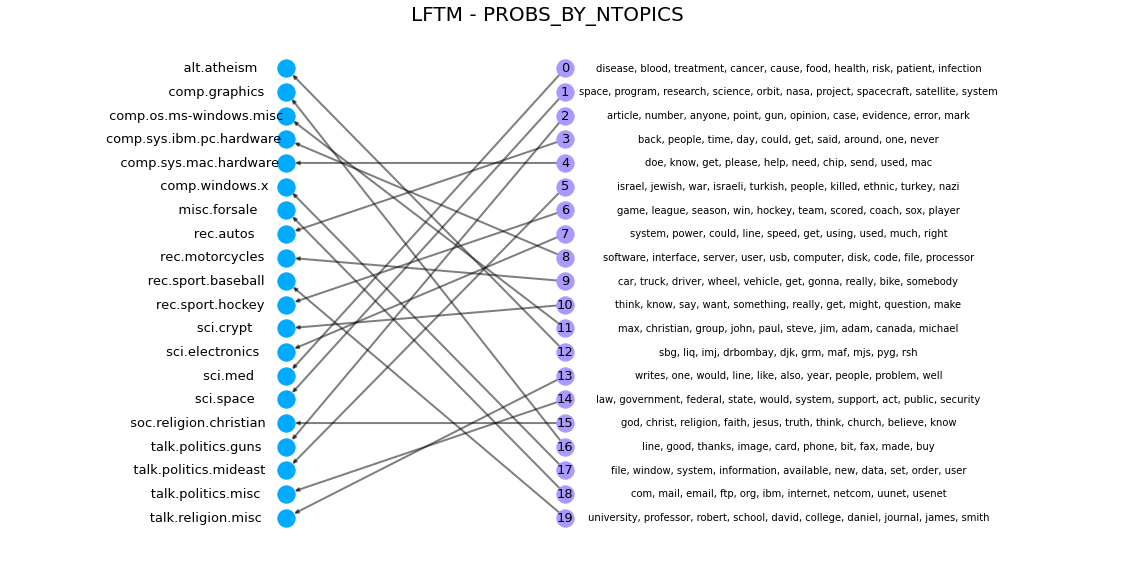

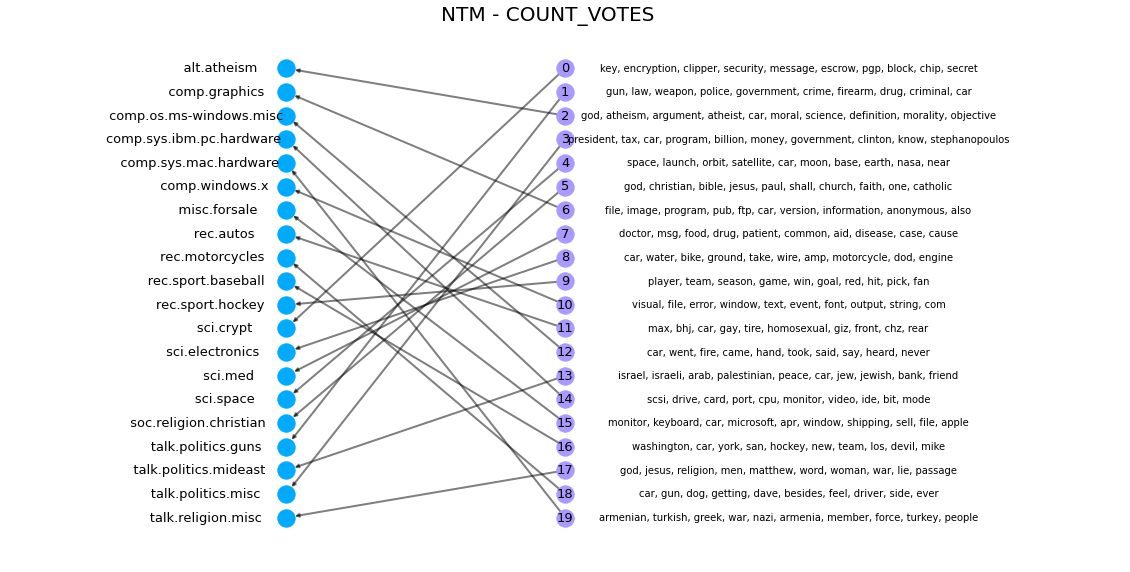

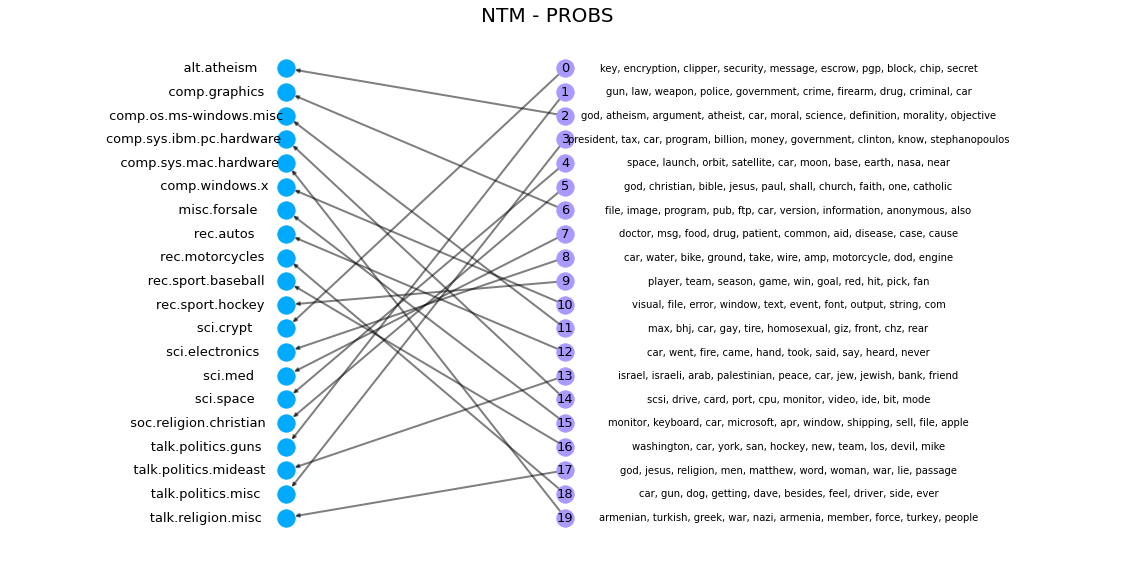

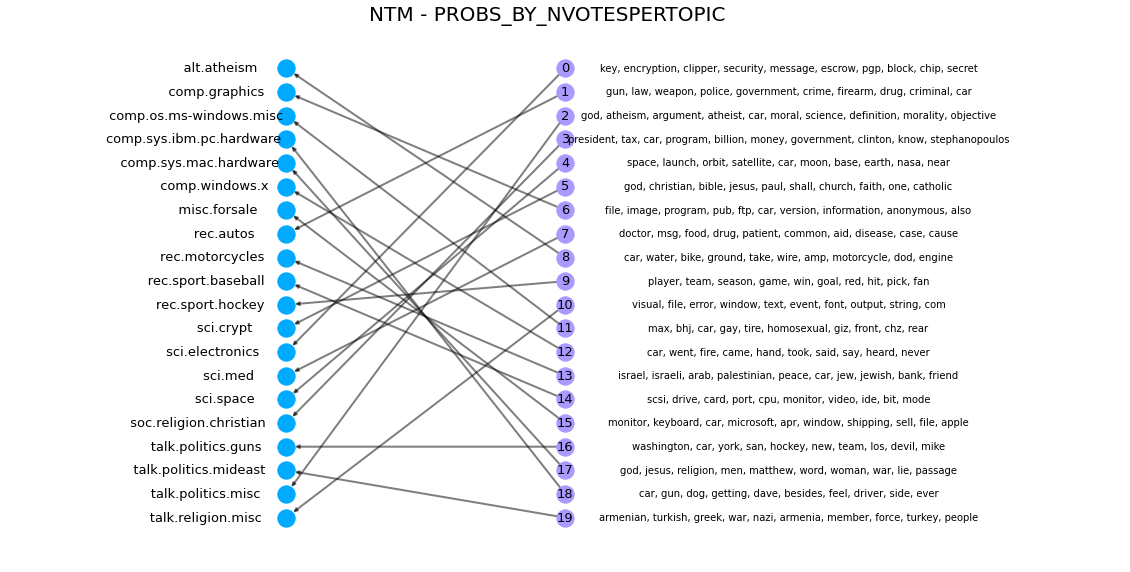

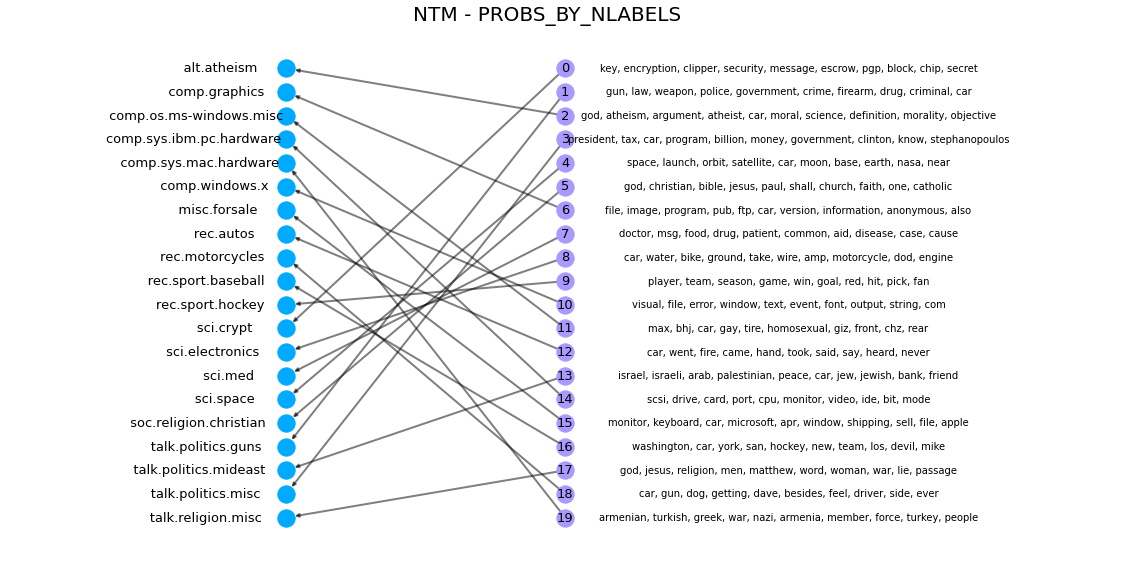

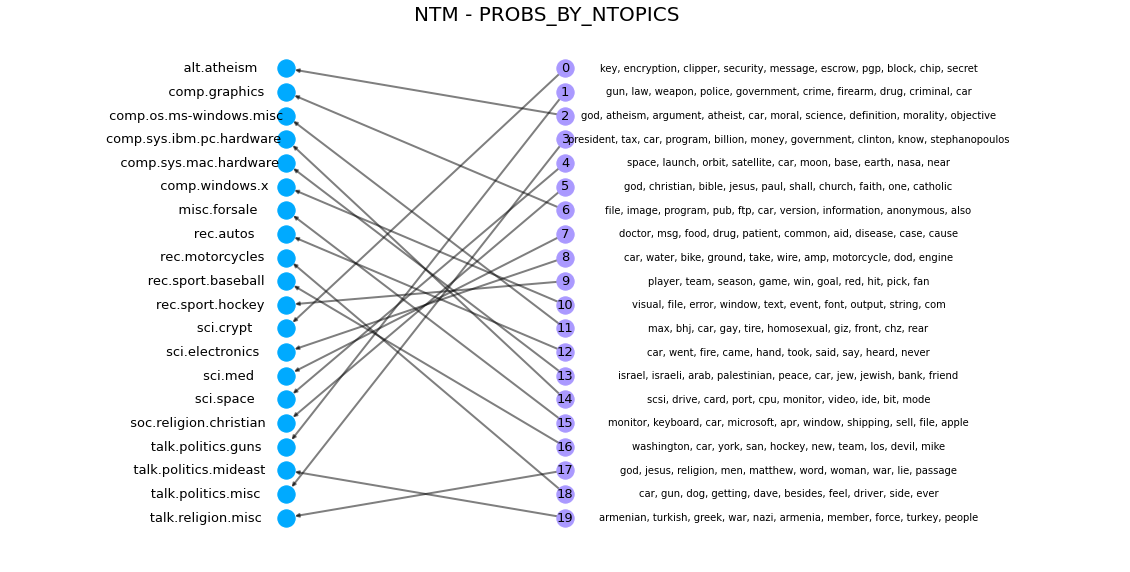

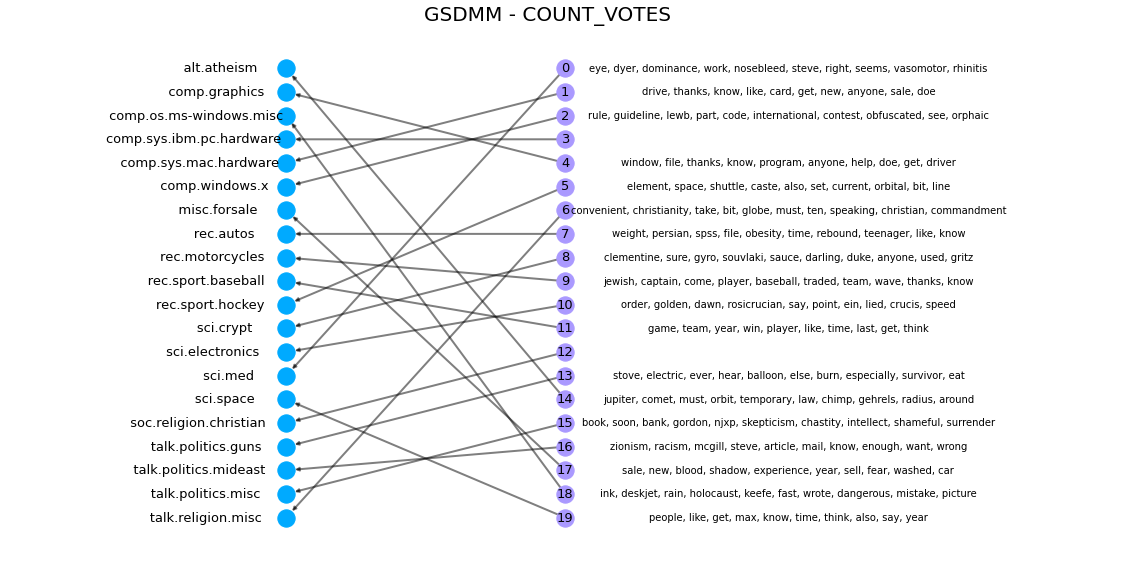

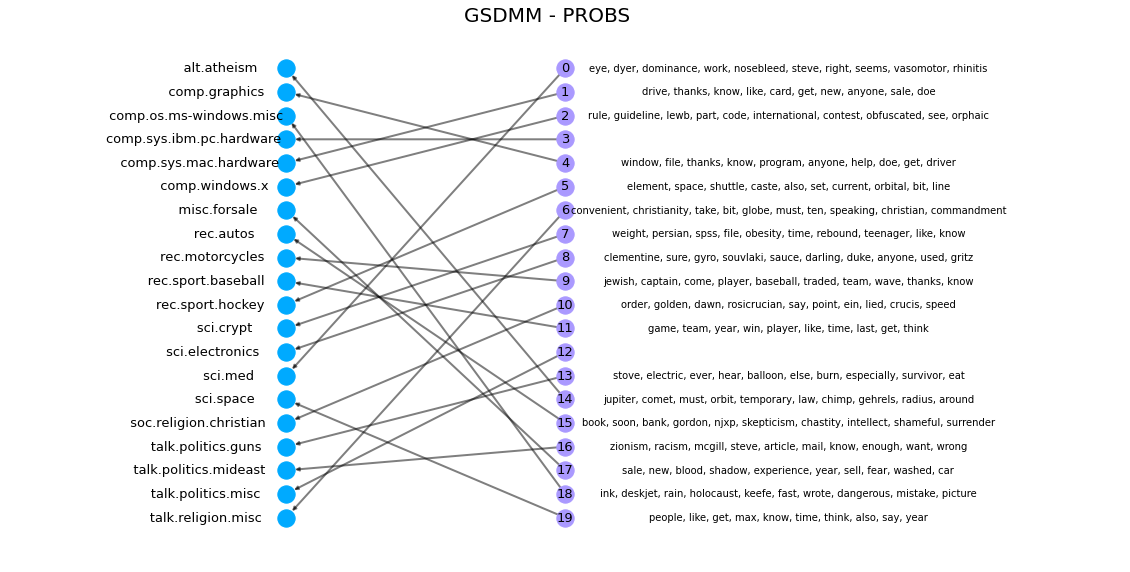

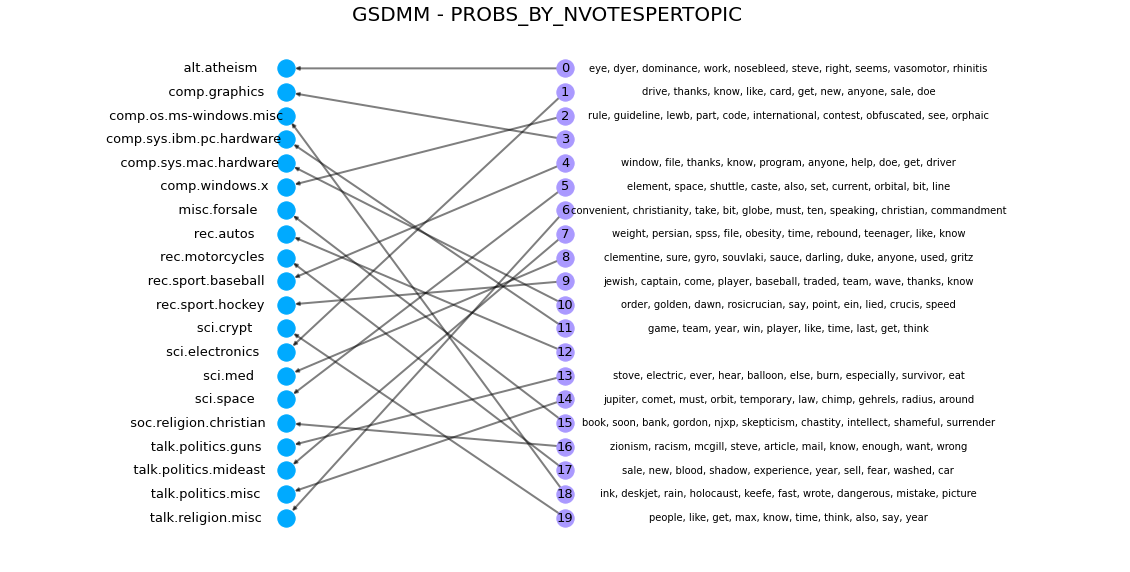

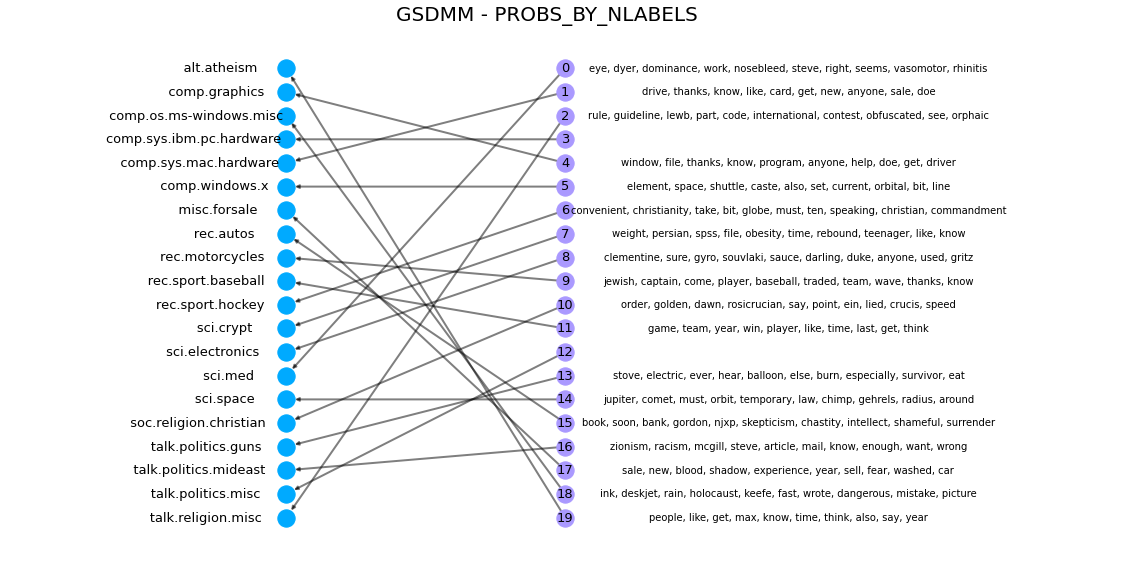

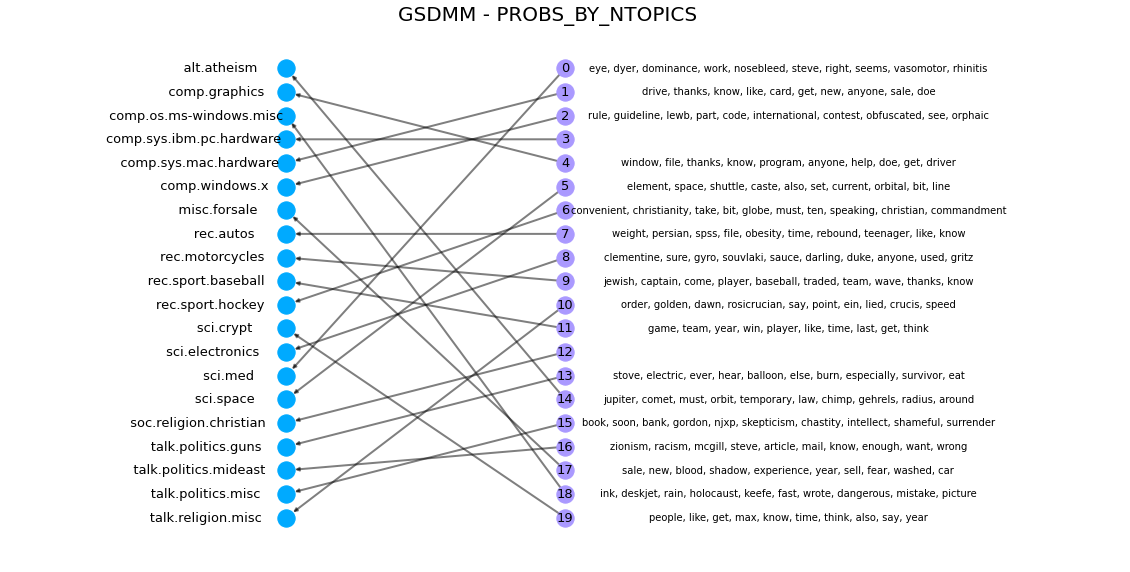

In [0]:
for model in models:
  for sm in topic_mappings[model]:
    m = topic_mappings[model][sm]
    topic_ids, mapped_labels = m.keys(), set(m.values())
    edges = m.items()

    fig, ax = plt.subplots(figsize=(20,10)) 
    ax.axis('off')

    G = nx.DiGraph()
    G.add_nodes_from(topic_ids, bipartite=0)
    G.add_nodes_from(mapped_labels, bipartite=1)
    G.add_edges_from(edges)

    # Set the position of each node on the graph
    pos = {}
    # We use the same ordering in the Scoring Visualization just to make it look pretty :) -no edges will intersect-
    ordered_labels = sorted(mapped_labels) # [l for l in topic_dfs[model][sm].index if l in mapped_labels]
    ordered_topics = [int(i.split('_')[1]) for i in topic_dfs[model][sm].columns]
    pos.update((node, (0.5, n_topics - 1 - index)) for index, node in enumerate(ordered_labels))
    pos.update((node, (1.5, n_topics - 1 - index)) for index, node in enumerate(ordered_topics))

    # nx.draw(G, pos, with_labels=False)
    nx.draw_networkx_nodes(G,pos,
                            nodelist= mapped_labels,
                            node_size=300,
                            node_color='#0af')
    
    nx.draw_networkx_nodes(G,pos,
                            nodelist= topic_ids,
                            node_size=300,
                            node_color='#a9f')
    

    nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='-|>', width=2, arrowsize=7, edge_color='#000', alpha=0.5)

    pos_keywords = {k: (v[0]+0.8, v[1]) for k, v in pos.items()}
    pos_labels   = {k: (v[0]-0.45, v[1]) for k, v in pos.items()}

    nx.draw_networkx_labels(G,pos_labels, {l:str.rjust(l, 40) for l in mapped_labels},font_size=13)
    nx.draw_networkx_labels(G,pos, {t:t for t in topic_ids},font_size=13)
    nx.draw_networkx_labels(G,pos_keywords, topic_keywords[model],font_size=10)

    fig.suptitle(model.upper() + ' - ' + sm.upper(), fontsize=20, y=0.9)
    plt.xlim(-0.5, 3.5)
    plt.savefig(f'{model}_mapping_{sm}.png')
    plt.show()

In [0]:
metrics = ['r1_accuracy', 'r3_accuracy', 'homogeneity', 'completeness', 'v_measure', 'purity', 'average']
scores  = {}

for sm in scoring_methods:
  print('Scoring model:', sm.upper())
  for model in models:
    score   = {}
    topic_to_label = lambda t: '' if t == -1 else topic_mappings[model][sm][t]
    y_true    = predictions['true']
    y_pred    = predictions[model+'_topic_0'].apply(topic_to_label)
    y_pred_2  = predictions[model+'_topic_1'].apply(topic_to_label)
    y_pred_3  = predictions[model+'_topic_2'].apply(topic_to_label)
    contingency_matrix = skm.cluster.contingency_matrix(y_true, y_pred)

    score['r1_accuracy']   = skm.accuracy_score(y_true, y_pred)
    score['r3_accuracy']   = skm.accuracy_score(y_true, y_pred) + skm.accuracy_score(y_true, y_pred_2) + skm.accuracy_score(y_true, y_pred_3)
    score['homogeneity']   = skm.homogeneity_score(y_true, y_pred)
    score['completeness']  = skm.completeness_score(y_true, y_pred)
    score['v_measure']     = skm.v_measure_score(y_true, y_pred) # Also NMI
    score['purity']        = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 
    score['average']       = np.average([s for k, s in score.items()])

    scores[model] = score

  header = 'model    ' + ' '.join(str.ljust(m, 13) for m in metrics)
  print(header)
  print('-'*len(header))
  for model in models:
    scorer = lambda model, metric: str.ljust(str(round(scores[model][metric]*100, 2))+'%', 13)
    print(model.upper(), '\t  ', ' '.join(scorer(model, metric) for metric in metrics))
  print('\n')

Scoring model: COUNT_VOTES
model    r1_accuracy   r3_accuracy   homogeneity   completeness  v_measure     purity        average      
----------------------------------------------------------------------------------------------------------
LDA 	   60.41%        77.0%         61.68%        65.31%        63.45%        62.1%         64.99%       
LFTM 	   32.08%        50.22%        32.42%        36.38%        34.28%        32.89%        36.38%       
NTM 	   25.86%        43.4%         20.34%        20.56%        20.45%        29.33%        26.66%       
GSDMM 	   15.6%         21.88%        19.2%         37.01%        25.28%        16.63%        22.6%        


Scoring model: PROBS
model    r1_accuracy   r3_accuracy   homogeneity   completeness  v_measure     purity        average      
----------------------------------------------------------------------------------------------------------
LDA 	   60.41%        77.0%         61.68%        65.31%        63.45%        62.1%         64.

In [0]:
metrics = ['Accuracy', 'Accuracy@3', 'Purity', 'Homogeneity', 'Completeness', 'V-Measure', 'Average']
scores  = {}
scores_print = {}
SMs  =  {'COUNT_VOTES': 'SM1', 'PROBS':"SM2", 'PROBS_BY_NVOTESPERTOPIC':"SM5", 'PROBS_BY_NLABELS':"SM3", 'PROBS_BY_NTOPICS': "SM4"}

for sm in scoring_methods:
  for model in models:
    if model not in scores_print: scores_print[model] = []
    score   = {}
    topic_to_label = lambda t: '' if t == -1 else topic_mappings[model][sm][t]
    y_true    = predictions['true']
    y_pred    = predictions[model+'_topic_0'].apply(topic_to_label)
    y_pred_2  = predictions[model+'_topic_1'].apply(topic_to_label)
    y_pred_3  = predictions[model+'_topic_2'].apply(topic_to_label)
    contingency_matrix = skm.cluster.contingency_matrix(y_true, predictions[model+'_topic_0'])

    score['Accuracy']   = skm.accuracy_score(y_true, y_pred)
    score['Accuracy@3']   = skm.accuracy_score(y_true, y_pred) + skm.accuracy_score(y_true, y_pred_2) + skm.accuracy_score(y_true, y_pred_3)
    score['Purity']        = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 
    score['Homogeneity']   = skm.homogeneity_score(y_true, y_pred)
    score['Completeness']  = skm.completeness_score(y_true, y_pred)
    score['V-Measure']     = skm.v_measure_score(y_true, y_pred) # Also NMI
    score['Average']       = np.average([s for k, s in score.items()])

    scores[model] = score

  for model in models:
    scorer = lambda model, metric: str.ljust(str(round(scores[model][metric]*100, 2))+'\%', 13)
    # print(model.upper(), '\t  ', ' '.join(scorer(model, metric) for metric in metrics))

    scores_print[model].append('& '.join([model.upper() + '  \t ', str.ljust(SMs[sm.upper()], 7), '& '.join(scorer(model, metric) for metric in metrics)]) + '\\\\')



header = 'model       &   ' + str.ljust('SM', 7)  + '& '+ '& '.join(str.ljust(m, 13) for m in metrics) + '\\\\'
print('  ', header)
print('  ', '-'*len(header))
for model in models:
  for sent in scores_print[model]:
    print('  ', sent)
  # print('  ', '-'*len(header))
  print('    \\hline')

   model       &   SM     & Accuracy     & Accuracy@3   & Purity       & Homogeneity  & Completeness & V-Measure    & Average      \\
   ----------------------------------------------------------------------------------------------------------------------------------
   LDA  	 & SM1    & 60.41\%      & 77.0\%       & 62.1\%       & 61.68\%      & 65.31\%      & 63.45\%      & 64.99\%      \\
   LDA  	 & SM2    & 60.41\%      & 77.0\%       & 62.1\%       & 61.68\%      & 65.31\%      & 63.45\%      & 64.99\%      \\
   LDA  	 & SM5    & 39.27\%      & 54.69\%      & 62.1\%       & 61.68\%      & 65.31\%      & 63.45\%      & 57.75\%      \\
   LDA  	 & SM3    & 60.41\%      & 77.0\%       & 62.1\%       & 61.68\%      & 65.31\%      & 63.45\%      & 64.99\%      \\
   LDA  	 & SM4    & 60.22\%      & 78.68\%      & 62.1\%       & 61.68\%      & 65.31\%      & 63.45\%      & 65.24\%      \\
    \hline
   LFTM  	 & SM1    & 32.08\%      & 50.22\%      & 32.89\%      & 32.42\%      & 36.3